In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error
register_matplotlib_converters()
from math import sqrt
import matplotlib.dates as mdates

In [2]:
# Load the dataset
demand_df = pd.read_csv('Product Demand.csv')
demand_df.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0965,St john's,Category_006,2014-01-08,2.0
1,Product_1724,St john's,Category_003,2014-05-31,108.0
2,Product_1521,Surrey,Category_019,2014-06-24,85000.0
3,Product_1521,Surrey,Category_019,2014-06-24,7000.0
4,Product_1507,Oshawa,Category_019,2014-09-02,1250.0


In [3]:
demand_df['Date'] = pd.to_datetime(demand_df['Date'], errors='coerce')
demand_df = demand_df.dropna(subset=['Date'])
demand_df.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0965,St john's,Category_006,2014-01-08,2.0
1,Product_1724,St john's,Category_003,2014-05-31,108.0
2,Product_1521,Surrey,Category_019,2014-06-24,85000.0
3,Product_1521,Surrey,Category_019,2014-06-24,7000.0
4,Product_1507,Oshawa,Category_019,2014-09-02,1250.0


In [4]:
# Aggregate order demand by year
yearly_demand = demand_df.groupby(pd.Grouper(key='Date', freq='Y'))['Order_Demand'].sum()
#yearly_demand = demand_df['Order_Demand'].resample('Y').sum()
print(yearly_demand)

Date
2014-12-31    8.363894e+06
2015-12-31    9.458575e+08
2016-12-31    1.014088e+09
2017-12-31    1.071473e+09
2018-12-31    1.099398e+09
2019-12-31    4.619423e+08
Freq: A-DEC, Name: Order_Demand, dtype: float64


### Data Visualization

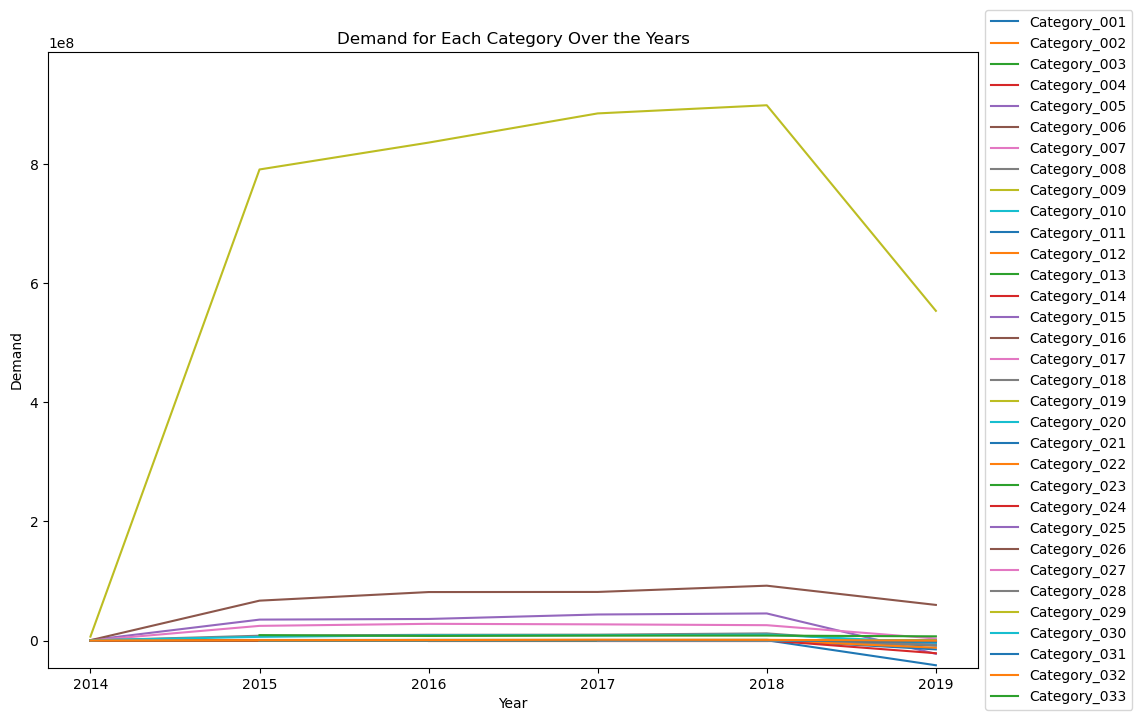

In [26]:
demand_df['Year'] = demand_df['Date'].dt.year
# Group by category and year, summing the demand
category_demand = demand_df.groupby(['Product_Category', 'Year']).agg({'Order_Demand': 'sum'}).reset_index()

# Plot demand for each category over the years
plt.figure(figsize=(12, 8))
for category in category_demand['Product_Category'].unique():
    category_data = category_demand[category_demand['Product_Category'] == category]
    plt.plot(category_data['Year'], category_data['Order_Demand'], label=category)

plt.title('Demand for Each Category Over the Years')
plt.xlabel('Year')
plt.ylabel('Demand')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

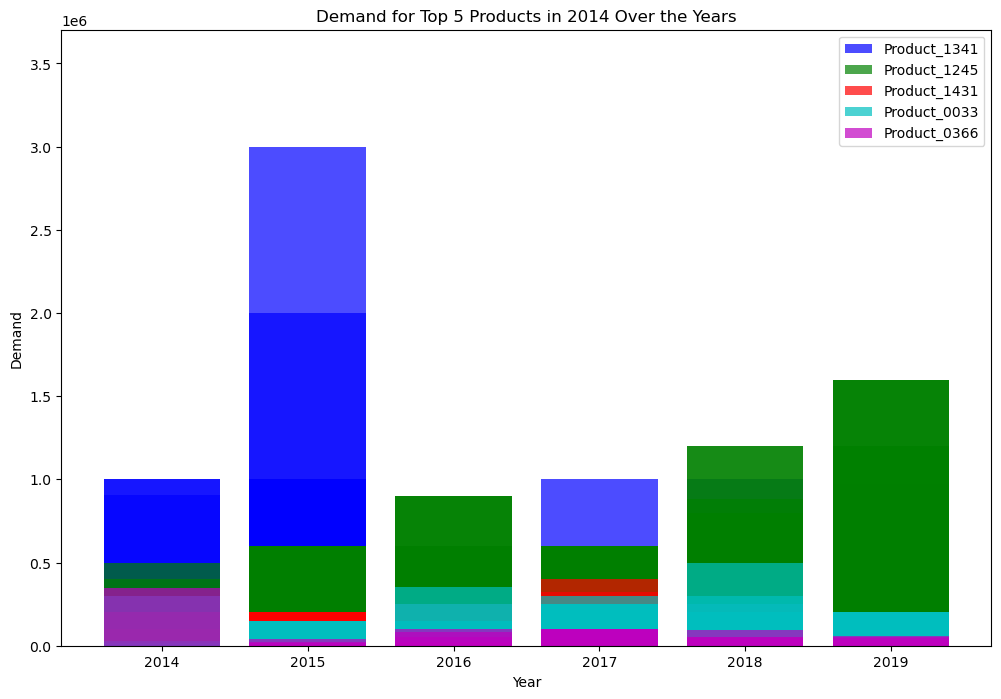

In [27]:
# Filter data for the year 2014
data_2014 = demand_df[demand_df['Year'] == 2014]

# Group by product and sum the demand
product_demand_2014 = data_2014.groupby('Product_Code').agg({'Order_Demand': 'sum'}).reset_index()

# Sort by demand in descending order and get the top 5 products
top_5_products_2014 = product_demand_2014.nlargest(5, 'Order_Demand')

# Create a color map for the bars
colors = ['b', 'g', 'r', 'c', 'm']

# Plot stacked bar chart
plt.figure(figsize=(12, 8))

for i, product in enumerate(top_5_products_2014['Product_Code']):
    product_data = demand_df[demand_df['Product_Code'] == product]
    years = product_data['Year']
    demand = product_data['Order_Demand']
    plt.bar(years, demand, label=product, color=colors[i], alpha=0.7)

plt.title('Demand for Top 5 Products in 2014 Over the Years')
plt.xlabel('Year')
plt.ylabel('Demand')
plt.legend()
plt.show()

### Demand Forecasting using ARIMA

In [7]:
# Splitting the cleaned data into training and test sets
split_point = int(len(yearly_demand) * 0.8)
train_data = yearly_demand.iloc[:split_point]
test_data = yearly_demand.iloc[split_point:]

In [8]:
# Check for stationarity with Augmented Dickey-Fuller test
def check_stationarity(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))


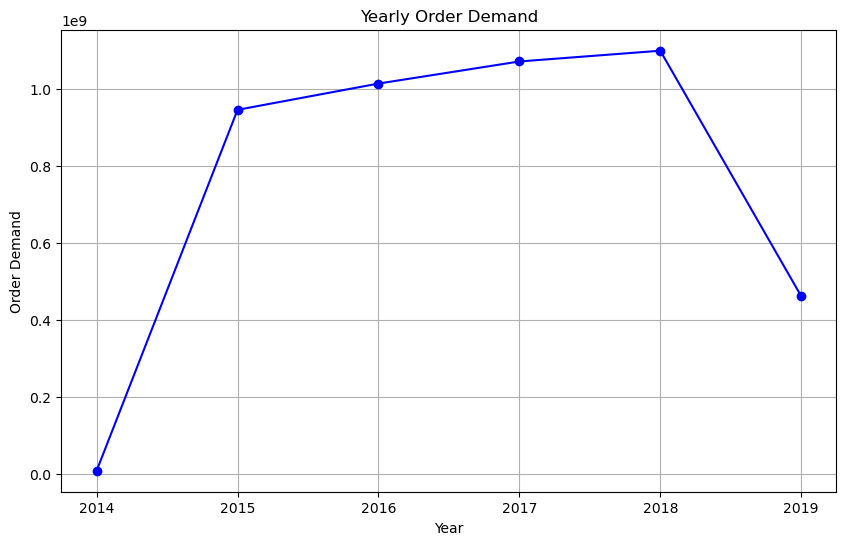

In [9]:
# Plotting the yearly demand
plt.figure(figsize=(10, 6))
plt.plot(yearly_demand.index.year, yearly_demand, marker='o', linestyle='-', color='b')
plt.title('Yearly Order Demand')
plt.xlabel('Year')
plt.ylabel('Order Demand')
plt.grid(True)
plt.show()

In [10]:
# Perform and display the Augmented Dickey-Fuller test results
check_stationarity(yearly_demand)

ADF Statistic: -3.305607
p-value: 0.014630
Critical Values:
	1%: -6.045
	5%: -3.929
	10%: -2.987


In [11]:
# Fit ARIMA model (with d=0 since the series is already stationary)
model = ARIMA(train_data, order=(1, 0, 1))
model_fit = model.fit()

C:\Users\deejd\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


In [12]:
# Forecast on test data
forecast = model_fit.forecast(steps=len(test_data))
forecast_index = test_data.index

In [13]:
# Calculate error metrics
mae = mean_absolute_error(test_data, forecast)
mse = mean_squared_error(test_data, forecast)
rmse = np.sqrt(mse)

print("Mean Absolute Error (MAE) on Test Data:", mae)
print("Mean Squared Error (MSE) on Test Data:", mse)
print("Root Mean Squared Error (RMSE) on Test Data:", rmse)

Mean Absolute Error (MAE) on Test Data: 357743363.3396406
Mean Squared Error (MSE) on Test Data: 1.416135204473082e+17
Root Mean Squared Error (RMSE) on Test Data: 376315719.10738486


In [14]:
model = ARIMA(yearly_demand, order=(1, 0, 1))
model_fit = model.fit()

C:\Users\deejd\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\deejd\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [15]:
# Forecasting the next year
forecast = model_fit.get_forecast(steps=1)
forecast_summary = forecast.summary_frame()

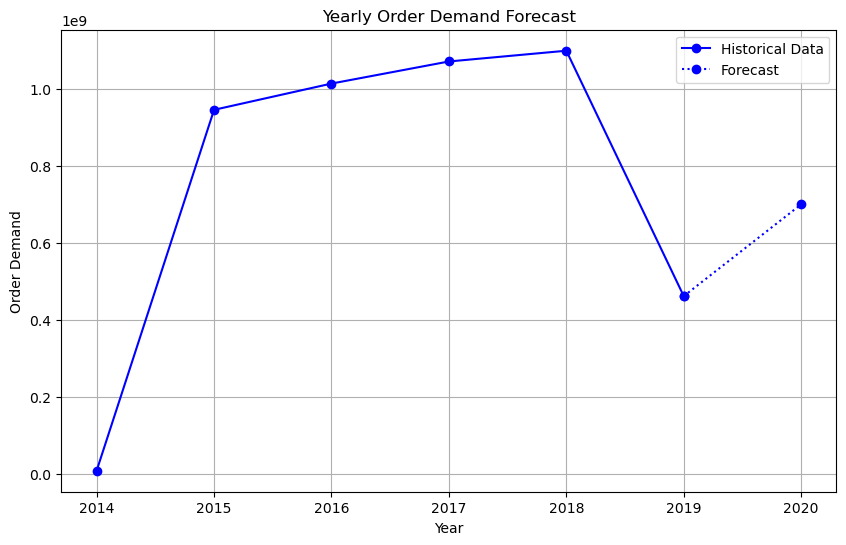

In [16]:
# Extracting years from the index and converting to integers for plotting
years = np.array(yearly_demand.index.year)

# Adding the forecast year to the years array
forecast_year = years[-1] + 1
all_years = np.append(years, forecast_year)
all_demand_values = np.append(yearly_demand, forecast_summary['mean'].values)
# Plotting historical data and forecast
plt.figure(figsize=(10, 6))
plt.plot(years, yearly_demand, marker='o', linestyle='-', color='b', label='Historical Data')

# Plotting the line to the forecasted demand with a dotted line
plt.plot(all_years[-2:], all_demand_values[-2:], marker='o', linestyle=':', color='b', label='Forecast')

# Adding forecast point
plt.plot(forecast_year, forecast_summary['mean'].values)

plt.title('Yearly Order Demand Forecast')
plt.xlabel('Year')
plt.ylabel('Order Demand')
plt.grid(True)
plt.legend()

plt.show()


In [17]:
# Aggregate order demand by year and category
yearly_demand_by_category = demand_df.groupby(['Product_Category', pd.Grouper(key='Date', freq='Y')])['Order_Demand'].sum().reset_index()
#yearly_demand_by_category =demand_df.groupby('Product_Category').resample('Y').sum().reset_index()

## Using Simple Exponential Smoothening

In [18]:
# Filter data for the year 2019
data_2019 = demand_df[demand_df['Year'] == 2019]

# Find the category with the highest demand in 2019
category_highest_demand_2019 = data_2019.groupby('Product_Category').agg({'Order_Demand': 'sum'}).idxmax()['Order_Demand']
print("Highest demand Category in 2019:", category_highest_demand_2019)
# Filter data for the category with the highest demand in 2019
category_data_2019 = data_2019[data_2019['Product_Category'] == category_highest_demand_2019]

# Find the product with the highest demand in the category with the highest demand in 2019
highest_demand_product = category_data_2019.groupby('Product_Code').agg({'Order_Demand': 'sum'}).idxmax()['Order_Demand']
print("Highest demand Product in 2019:", highest_demand_product)
# Filter data for the highest demand product
highest_demand_product_data = demand_df[demand_df['Product_Code'] == highest_demand_product]

# Perform simple exponential smoothing
model = ExponentialSmoothing(highest_demand_product_data['Order_Demand'], seasonal_periods=12, trend='add', seasonal='add').fit()
forecast = model.forecast(steps=1)
print("Forecasted demand for the highest demand product in 2019:", forecast)

Highest demand Category in 2019: Category_019
Highest demand Product in 2019: Product_1359


C:\Users\deejd\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\deejd\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\deejd\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\deejd\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Forecasted demand for the highest demand product in 2019: 17021    27904.270773
dtype: float64


In [19]:
# Filter the dataset for Product_0965
product_data = demand_df[demand_df['Product_Code'] == 'Product_0965']
# Re-aggregate order demand by date
# Aggregate demand by date
product_demand = product_data.groupby('Date')['Order_Demand'].sum().reset_index()

In [20]:
# Split the data into training and test sets (80% training, 20% testing)
split_point = int(len(product_demand) * 0.8)
train, test = product_demand.iloc[:split_point], product_demand.iloc[split_point:]
# Set the Date column as the index
train.set_index('Date', inplace=True)
test.set_index('Date', inplace=True)


In [21]:
# Assuming monthly seasonality
seasonal_period = 12

hw_model_train = ExponentialSmoothing(train['Order_Demand'], 
                                      trend='add', seasonal='add', seasonal_periods=seasonal_period).fit()


C:\Users\deejd\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [22]:
# Forecast the demand for the duration of the test dataset
forecast_values = hw_model_train.forecast(len(test))

# Calculate the RMSE
rmse = sqrt(mean_squared_error(test['Order_Demand'], forecast_values))
mae = mean_absolute_error(test['Order_Demand'], forecast_values)
mse = mean_squared_error(test['Order_Demand'], forecast_values)


# Output the error matrix
print("Mean Absolute Error (MAE) on Test Data:", mae)
print("Mean Squared Error (MSE) on Test Data:", mse)
print("Root Mean Squared Error (RMSE) on Test Data:", rmse)

Mean Absolute Error (MAE) on Test Data: 1.2850034503790644
Mean Squared Error (MSE) on Test Data: 2.4898620643204206
Root Mean Squared Error (RMSE) on Test Data: 1.5779296766080613


C:\Users\deejd\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\deejd\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


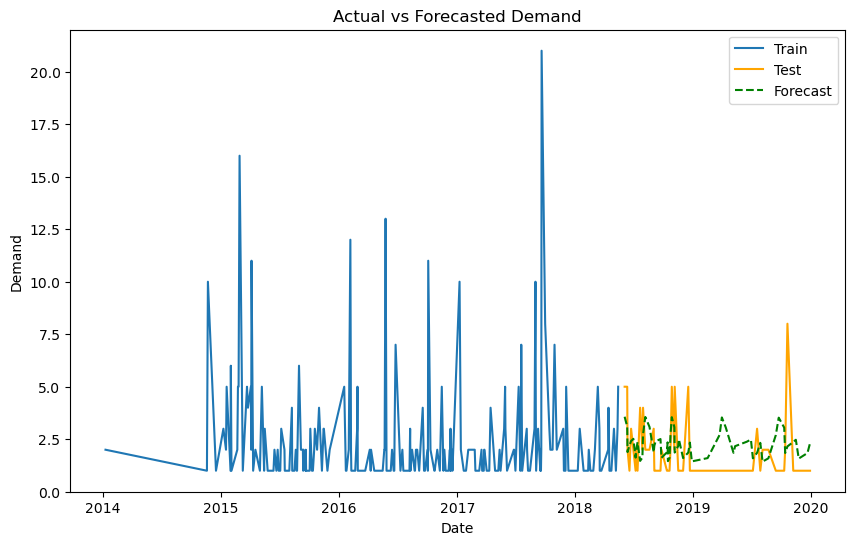

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(train.index, train['Order_Demand'], label='Train')
plt.plot(test.index, test['Order_Demand'], label='Test', color='orange')
plt.plot(test.index, forecast_values, label='Forecast', color='green', linestyle='--')
# Formatting the date axis
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.title('Actual vs Forecasted Demand')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.legend()
plt.show()

In [24]:
forecast_results = []

for category in yearly_demand_by_category['Product_Category'].unique():
    # Filter the data for the current category
    category_data = yearly_demand_by_category[yearly_demand_by_category['Product_Category'] == category]
    category_data.set_index('Date', inplace=True)
    
    # Fit ARIMA model
    model = ARIMA(category_data['Order_Demand'], order=(1, 0, 1))
    model_fit = model.fit()
    
    # Forecast the next year
    forecast = model_fit.get_forecast(steps=1)
    forecast_summary = forecast.summary_frame()
    
    forecast_results.append({
        'Product_Category': category,
        'Forecast': forecast_summary['mean'].values[0]
    })

C:\Users\deejd\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency A-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\deejd\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency A-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\deejd\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency A-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\deejd\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\deejd\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so i

C:\Users\deejd\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\deejd\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency A-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\deejd\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency A-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\deejd\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency A-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\deejd\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Usin

C:\Users\deejd\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency A-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\deejd\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency A-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\deejd\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency A-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\deejd\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\deejd\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting

C:\Users\deejd\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency A-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\deejd\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency A-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\deejd\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency A-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\deejd\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\deejd\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting

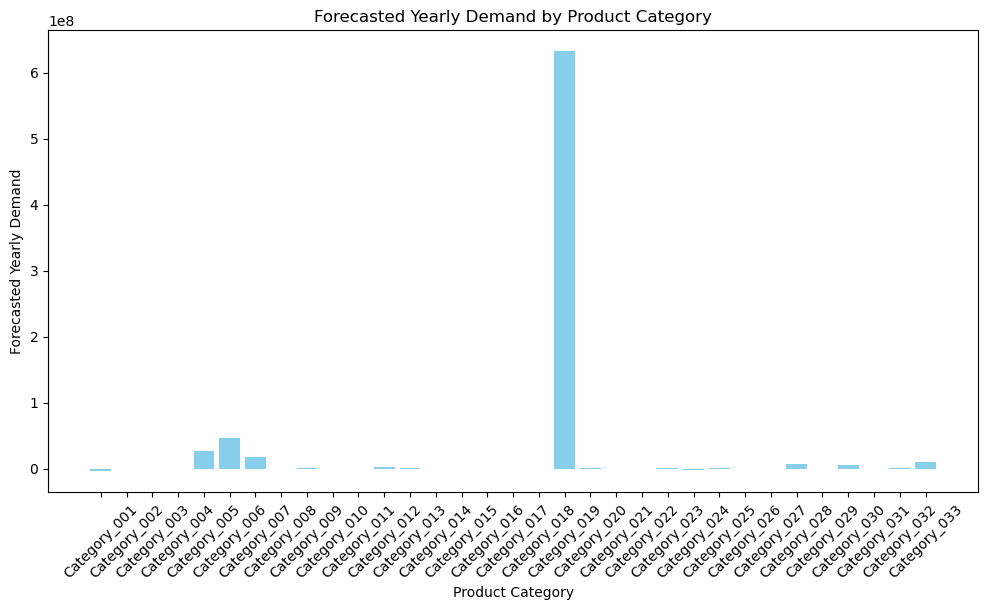

In [25]:
forecast_df = pd.DataFrame(forecast_results)

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(forecast_df['Product_Category'], forecast_df['Forecast'], color='skyblue')
plt.xlabel('Product Category')
plt.ylabel('Forecasted Yearly Demand')
plt.title('Forecasted Yearly Demand by Product Category')
plt.xticks(rotation=45)
plt.show()